# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    #line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    #draw_lines(line_img, lines)
    return lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)
"""
The following functions are used to consolidate and extrapolate the detected hough lines

"""
def average_slope_intercept(lines):
    left_lines    = [] # (slope, intercept)
    left_weights  = [] # (length,)
    right_lines   = [] # (slope, intercept)
    right_weights = [] # (length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x2==x1:
                continue # ignore a vertical line
            slope = (y2-y1)/(x2-x1)
            intercept = y1 - slope*x1
            length = np.sqrt((y2-y1)**2+(x2-x1)**2)
            if slope < 0: # y is reversed in image
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    
    # add more weight to longer lines    
    left_lane  = np.dot(left_weights,  left_lines) /np.sum(left_weights)  if len(left_weights) >0 else None
    right_lane = np.dot(right_weights, right_lines)/np.sum(right_weights) if len(right_weights)>0 else None
    
    return left_lane, right_lane # (slope, intercept), (slope, intercept)
"""
make_lane_points returns the points to create the line(pixels) using the input from lane_lines
"""
def make_line_points(y1, y2, line):
    if line is None:
        return None
    
    slope, intercept = line
    
    # make sure everything is integer as cv2.line requires it
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    
    return ((x1, y1), (x2, y2))
"""    
lane_lines(also in the main pipeline) takes the original image and the image with the hough lines draw
it calls the average_slope_intercept to get the average slopes sets two variables(points) to the bottom of the 
image and slightly below the middle and calls the make_line_points function for both left and right lanes
"""
def lane_lines(image, lines):
    left_lane, right_lane = average_slope_intercept(lines)
    
    y1 = image.shape[0] # bottom of the image
    y2 = y1*0.6         # slightly lower than the middle

    left_line  = make_line_points(y1, y2, left_lane)
    right_line = make_line_points(y1, y2, right_lane)
    
    return left_line, right_line

"""
The function draw_lane_lines is called in the main pipeline with the original image and the result of the
lane_lines function
"""    
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=20):
    # make a separate image to draw lines and combine with the orignal later
    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    # image1 * α + image2 * β + λ
    # image1 and image2 must be the same shape.
    return cv2.addWeighted(image, 1.0, line_image, 0.95, 0.0)

In [3]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Lane Finding Pipeline



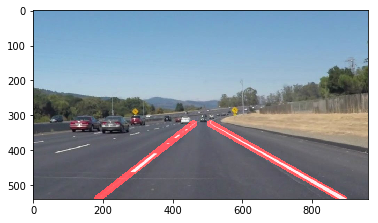

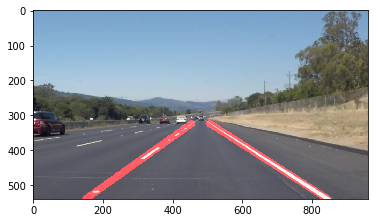

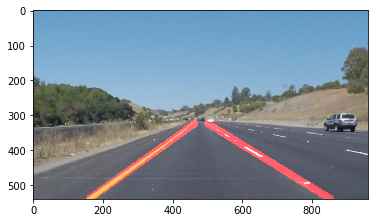

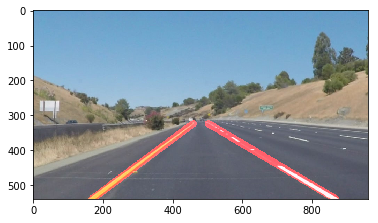

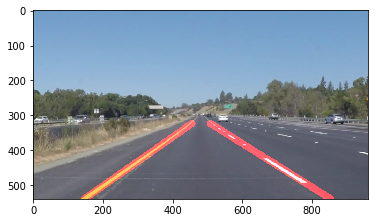

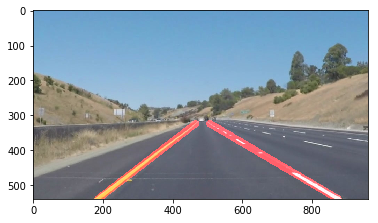

In [4]:
# Read in and grayscale the image

def LaneFindPipeline(image):
    gray = grayscale(image)

    hsl = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        
    #values to define color white boundaries in hsl
    lower_white = np.array([0,200,0], dtype = "uint8")
    upper_white = np.array([255,255,255], dtype = "uint8")

    #values to define yellow boundaries in hsl
    lower_yellow = np.array([10,0,100], dtype = "uint8")
    upper_yellow = np.array([40,200,255], dtype = "uint8")

    #create NumPy arrays from the boundaries and create the masks
    lowerW = np.array(lower_white, dtype = "uint8")
    upperW = np.array(upper_white, dtype = "uint8")
    mask_white = cv2.inRange(hsl,lowerW,upperW)
    
    lowerY = np.array(lower_yellow, dtype = "uint8")
    upperY = np.array(upper_yellow, dtype = "uint8")
    mask_yellow = cv2.inRange(hsl,lowerY,upperY)
    
    #bitwise OR the white and yellow masks
    mask = cv2.bitwise_or(mask_white,mask_yellow)
    
    #bitwise AND the grayscale image and the mask
    output = cv2.bitwise_and(gray,gray,mask=mask)
    
    #gaussian blur with 13
    blur_gray = cv2.GaussianBlur(output,(13, 13),0)

    #canny edge detection
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    #set values for region of interest, percent based on image size
    rows, cols = edges.shape[:2]
    bottomLeft = [cols*.1, rows*.97]
    topLeft = [cols*.4, rows*.6]
    topRight = [cols*.6, rows*.6]
    bottomRight = [cols*.9, rows*.97]

    vertices = np.array([[bottomLeft,topLeft,topRight,bottomRight]], dtype=np.int32)

    masked_edges = region_of_interest(edges, vertices)
    
    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 #minimum number of pixels making up a line
    max_line_gap = 300   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    
    # Iterate over the output "lines" and draw lines on a blank image
    draw_lines(line_image, lines, color=[255, 0, 0], thickness=5)
    color_edges = np.dstack((edges, edges, edges))
    
    # Draw the lines on the edge image
    lane_images = []
    lines_edges = draw_lane_lines(image, lane_lines(image, lines))
    return lines_edges
"""
run the LaneFindPipeline function over the files in the directory
"""
for file in os.listdir("test_images/"):
    filename = os.fsdecode(file)
    if filename.endswith(".jpg"):
        res = LaneFindPipeline(mpimg.imread(os.path.join("test_images/", filename)))
        fig = plt.figure()
        plt.imshow(res)
        plt.figure()
        fig.savefig('./test_images_output/'+filename)
        continue
    else:
        continue
        
###################

In [5]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [6]:
"""
function calls our pipeline with the image frame from the video
"""
def process_image(image):
    result = LaneFindPipeline(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [7]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:04<00:00, 53.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 4.47 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [8]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [9]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:12<00:00, 53.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 13.1 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge (Completed)

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [11]:
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:08<00:00, 29.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 9.09 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))